In [306]:
%matplotlib inline

In [396]:
import re
import zipfile
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Mental disorders analysis

## Introduction

Nowadays, more and more people experience mental health disorders. For some, the symptoms improve over time without treatment, while others need professional therapy and support. Mental disorders can affect anyone, often triggered by factors we least expect. The most common conditions include Depression and Anxiety, while Obsessive Compulsive Disorder (OCD) is less frequent but still significant.

In this project, I will explore these disorders through five different datasets, aiming to answer important questions and better understand their patterns and impact.

## Plan
Although the project title is *Mental disorders analysis*, we are going to analize only a few like depression, anxiety and Obsessive Compulsive Disorder

Some words why I chose the datasets

Some questions to ask

Approaches

At the beginning we are going to clean some datasets. Then we will proceed to make some hypotesis and prove or reject them. We are also going to compare results from multiple datasets.

Then we will try to train a model using Regression that will try to predict whether a person has any of the above mentioned disorders.

In the end, we will try to find typical behavior for those disorders and then compare it to other disorders.

# Notes

## Data Cleanup

Let's begin by creating a function that will be used for renaming columns to *snake_case*

In [308]:
def to_snake_case(col_name):
    col_name = col_name.strip()
    col_name = col_name.lower()
    col_name = re.sub(r"[^\w\s]", "_", col_name) # replace non-alphanumeric characters with underscores
    col_name = re.sub(r"\s+", "_", col_name) # regex is used instead of replace to handle multiple spaces
    col_name = re.sub(r"_+", "_", col_name)  # replace multiple underscores with a single underscore
    col_name = col_name.rstrip("_")

    return col_name

Because we will mostly work with numerical data, we need a way to represent categorical data as integers.

In [311]:
# val1 and val2 are case insensitive and default to 'yes' and 'no'
def binary_encode(df, column, val1 = 'yes', val2 = 'no'):
    df[column] = df[column].str.lower().map({val1.lower(): 1, val2.lower(): 0})

In [312]:
# nominal encoding using OneHotEncoder
def one_hot_encode(df, column):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform="pandas")
    ohetransform = ohe.fit_transform(df[[column]])
    df = pd.concat([df, ohetransform], axis=1).drop(column, axis=1)

In [313]:
def ordinal_encode(df, column, categories_order):
    # Transform both the list and the column to lowercase for consistency and case insensitivity
    categories_order_lower = [cat.lower() for cat in categories_order]
    df[column] = df[column].str.lower()

    encoder = OrdinalEncoder(categories=[categories_order_lower])
    df[column] = encoder.fit_transform(df[[column]])

Of course, we will need some plotting functions

In [314]:
def plot_category_counts(df, column_name, title=None, xlabel=None, ylabel="Count"):
    category_stats = df[column_name].value_counts()
    
    categories = category_stats.index
    counts = category_stats.values

    plt.bar(categories, counts)
    plt.title(title if title else f"Students by {column_name}")
    plt.xlabel(xlabel if xlabel else column_name)
    plt.ylabel(ylabel)

    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom')

    plt.show()

### Student Depression

Let's start with the Student Depression Dataset.csv dataset.

In [315]:
student_depression_data = pd.read_csv('data/Student Depression Dataset.csv')

In [316]:
student_depression_data

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,No,1


In [317]:
student_depression_data.columns = [to_snake_case(c) for c in student_depression_data.columns]

First thing we notice is that there is a column *id* which we need to check for uniqueness

In [318]:
student_depression_data.id.nunique() == len(student_depression_data)

True

Since it has no repetitions we can safely remove the column

In [319]:
student_depression_data = student_depression_data.drop(columns=["id"])

First thing we notice is that the dataset contains a column named Profession. However, that column includes Student as a value. We also have Work/Study Hours.

In [320]:
profession_stats = student_depression_data.profession.value_counts()
profession_stats.columns = ["Profession", "Count"]
profession_stats

profession
Student                   27870
Architect                     8
Teacher                       6
Digital Marketer              3
Chef                          2
Content Writer                2
Pharmacist                    2
Doctor                        2
UX/UI Designer                1
Civil Engineer                1
Manager                       1
Educational Consultant        1
Lawyer                        1
Entrepreneur                  1
Name: count, dtype: int64

The bar chart says it all :)

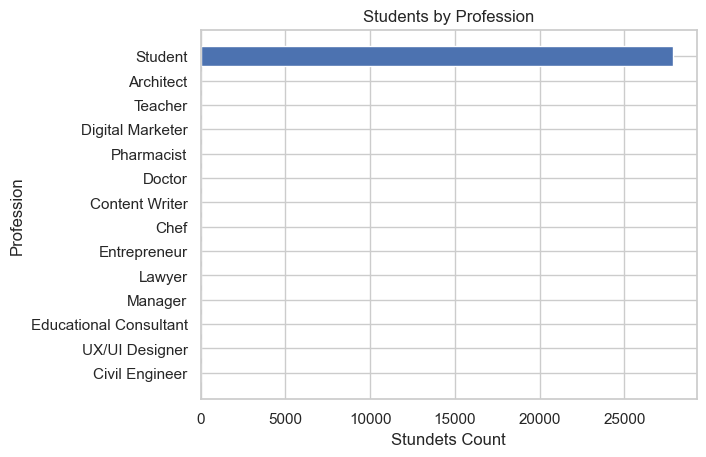

In [321]:
profession_stats = student_depression_data['profession'].value_counts(ascending=True)

professions = profession_stats.index
counts = profession_stats.values

# Horizontal bar chart so that profession names are fully visible
plt.barh(professions, counts)
plt.title("Students by Profession")
plt.xlabel("Stundets Count")
plt.ylabel("Profession")

plt.show()

As the name of the dataset suggests, it is about student. Data also shows it by having too little of the ramaining values. That is why I am going to assume that any other profession is not usable for any hypothesis and any row that is not a student will be considered to be an outlier and therefore be removed.

In [322]:
student_depression_data = student_depression_data[student_depression_data.profession == "Student"]

Let's not forget to rename the Work/Study Hours (that now is work_study_hours) since it would not make sense otherwise

In [323]:
student_depression_data = student_depression_data.rename(columns={"work_study_hours": "study_hours"})

We can also see that there are very few students that have a value for the column Job Satisfaction. However, the profession is Student. These students could either be studying and working or only studying but since the value in the previously named column Work/Job Hours was in one place, I will assume that this data is redundant and could be deleted.

In [324]:
student_depression_data.job_satisfaction.value_counts()

job_satisfaction
0.0    27862
2.0        3
4.0        2
1.0        2
3.0        1
Name: count, dtype: int64

In [325]:
student_depression_data = student_depression_data[student_depression_data.job_satisfaction == 0]
student_depression_data = student_depression_data.drop(columns=["job_satisfaction"])

Here we can see that there are diferent values for Work Pressure and since we already decided to test only for students that are not employed, I am going to drop those that are equal to 0

In [326]:
student_depression_data.work_pressure.value_counts()

work_pressure
0.0    27862
Name: count, dtype: int64

In [327]:
student_depression_data = student_depression_data.drop(columns=["work_pressure"])

Since we removed all records where the Profession column has a value diferrent than Student we can remove the whole column since it does not bring any new knowledge

In [328]:
student_depression_data = student_depression_data.drop(columns=["profession"])

Now in order to be more consistent I will translate the values of the folowing columns to 0 and 1 instead of Yes or No:

Have you ever had suicidal thoughts ?
Family History of Mental Illness

And the gender column to:

Male = 0 and Female = 1

But let's first see if there are values that are not Yes or No and Male or Female.

I encode male and female as 0 and 1 because there aren't other values and I assume such won't be added

In [329]:
binary_encode(student_depression_data, "have_you_ever_had_suicidal_thoughts")
binary_encode(student_depression_data, "family_history_of_mental_illness")
binary_encode(student_depression_data, "gender", "Male", "Female")

We have some ordinary categorical values that must be converted to numerical

I've picked *sleep_duration* and *dietary_habits* because both can be ordered incrementally.

Let's begin with *dietary_habits*.

First we need to see all possible values and order them incrementally.

In [330]:
student_depression_data.dietary_habits.unique()

array(['Healthy', 'Moderate', 'Unhealthy', 'Others'], dtype=object)

As we can see, we have four unique values. It is easy to order them like this: [Healthy, Moderate, Unhealthy] in somewhat of a descending order. I choose this order because of the semantics of the dataset. Because the dataset is about depression, it is logical *Healhy* to be the lowest.

However, there is a slight problem. There is also a *Others* value. What should we do with it?

In [331]:
student_depression_data.dietary_habits.value_counts()

dietary_habits
Unhealthy    10307
Moderate      9905
Healthy       7638
Others          12
Name: count, dtype: int64

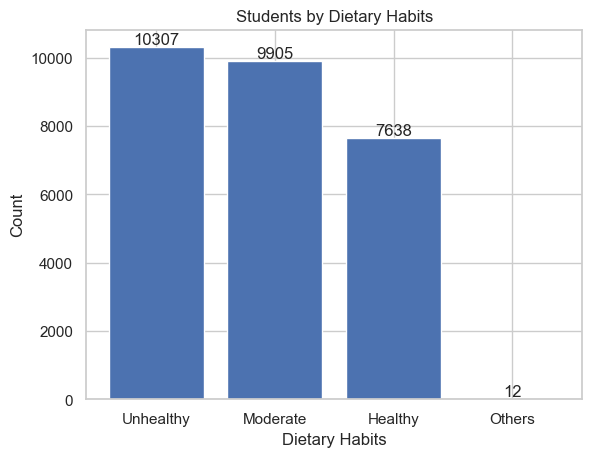

In [332]:
plot_category_counts(student_depression_data, "dietary_habits", title="Students by Dietary Habits", xlabel="Dietary Habits")

As we can see the case with the value *Others* is similar to the *profession* column we removed. It brings little to no entropy and we can just remove those values.

In [333]:
student_depression_data = student_depression_data[student_depression_data.dietary_habits != "Others"]

And we can finally convert the ordinal values to numerical using the *ordinal_encode* function.

In [335]:
student_depression_data.sleep_duration.unique()

array(['5-6 hours', 'Less than 5 hours', '7-8 hours', 'More than 8 hours',
       'Others'], dtype=object)

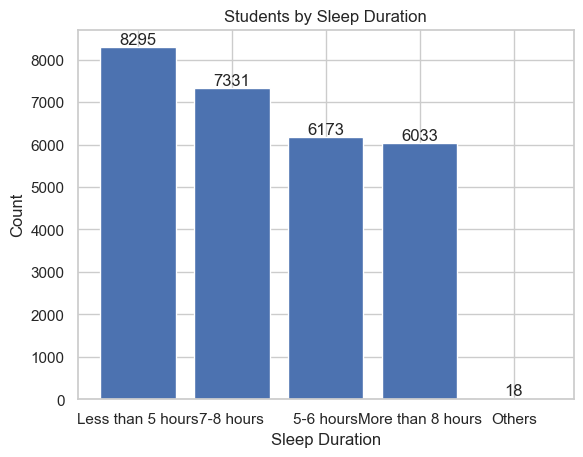

In [336]:
plot_category_counts(student_depression_data, "sleep_duration", title="Students by Sleep Duration", xlabel="Sleep Duration")

As we can see the situation of *sleep_duration* is similar to that of *dietary_habits* so we can again delete rows where the value is *Others*

In [337]:
student_depression_data = student_depression_data[student_depression_data.sleep_duration != "Others"]

In [338]:
ordinal_encode(student_depression_data, "dietary_habits", ["Healthy", "Moderate", "Unhealthy"])
ordinal_encode(student_depression_data, "sleep_duration", ["More than 8 hours", "7-8 hours", "5-6 hours", "Less than 5 hours"])

Finally, let's check if there are other than 1 and 0 in the depression column

In [339]:
student_depression_data.depression.value_counts()

depression
1    16287
0    11545
Name: count, dtype: int64

This is what the dataset looks after the cleanup

In [340]:
student_depression_data

,gender,age,city,academic_pressure,cgpa,study_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts,study_hours,financial_stress,family_history_of_mental_illness,depression
0,1,33.0,Visakhapatnam,5.0,8.97,2.0,2.0,0.0,B.Pharm,1,3.0,1.0,0,1
1,0,24.0,Bangalore,2.0,5.90,5.0,2.0,1.0,BSc,0,3.0,2.0,1,0
2,1,31.0,Srinagar,3.0,7.03,5.0,3.0,0.0,BA,0,9.0,1.0,1,0
3,0,28.0,Varanasi,3.0,5.59,2.0,1.0,1.0,BCA,1,4.0,5.0,1,1
4,0,25.0,Jaipur,4.0,8.13,3.0,2.0,1.0,M.Tech,1,1.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,0,27.0,Surat,5.0,5.75,5.0,2.0,2.0,Class 12,1,7.0,1.0,1,0
27897,1,27.0,Ludhiana,2.0,9.40,3.0,3.0,0.0,MSc,0,0.0,3.0,1,0
27898,1,31.0,Faridabad,3.0,6.61,4.0,2.0,2.0,MD,0,12.0,2.0,0,0
27899,0,18.0,Ludhiana,5.0,6.88,2.0,3.0,0.0,Class 12,1,10.0,5.0,0,1


The dataset looks good. Let's now proceed with the second dataset about depression.

### Enhanced Anxiety

In [341]:
enhanced_anxiety_data = pd.read_csv('data/enhanced_anxiety_dataset.csv')

In [342]:
enhanced_anxiety_data

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,23,Female,Engineer,6.1,3.1,566,9,Yes,No,8,91,28,1,Yes,Yes,1,No,3,6.0
10996,50,Other,Teacher,6.6,3.6,64,17,Yes,No,7,95,17,3,No,No,2,No,7,3.0
10997,29,Male,Nurse,6.7,6.9,159,14,No,No,8,72,16,1,Yes,Yes,2,Yes,7,4.0
10998,53,Other,Artist,5.7,2.7,248,8,No,No,4,112,28,3,Yes,Yes,1,Yes,2,4.0


In [343]:
enhanced_anxiety_data.columns = [to_snake_case(c) for c in enhanced_anxiety_data.columns]

In [344]:
print(f"smoking => {enhanced_anxiety_data.smoking.unique()}")
print(f"family_history_of_anxiety => {enhanced_anxiety_data.family_history_of_anxiety.unique()}")
print(f"dizziness => {enhanced_anxiety_data.dizziness.unique()}")
print(f"medication => {enhanced_anxiety_data.medication.unique()}")
print(f"recent_major_life_event => {enhanced_anxiety_data.recent_major_life_event.unique()}")

smoking => ['Yes' 'No']
family_history_of_anxiety => ['No' 'Yes']
dizziness => ['No' 'Yes']
medication => ['Yes' 'No']
recent_major_life_event => ['Yes' 'No']


In [345]:
binary_encode(enhanced_anxiety_data, "smoking")
binary_encode(enhanced_anxiety_data, "family_history_of_anxiety")
binary_encode(enhanced_anxiety_data, "dizziness")
binary_encode(enhanced_anxiety_data, "medication")
binary_encode(enhanced_anxiety_data, "recent_major_life_event")

In [346]:
print(f"gender => {enhanced_anxiety_data.gender.unique()}")

gender => ['Female' 'Other' 'Male']


We can notice that in this dataset exist records whose gender is *other*.

Let's check the distribution of the column so we know what to do with those rows.

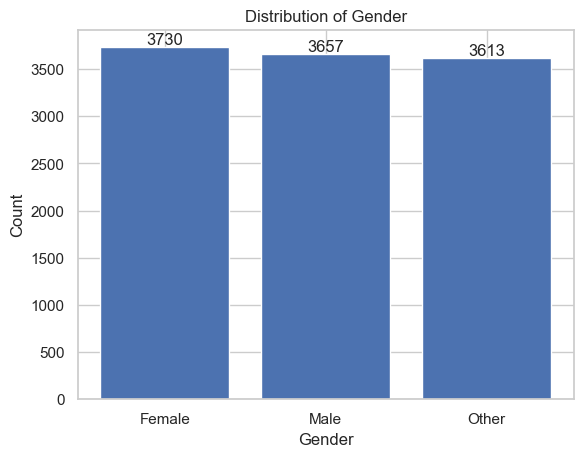

In [347]:
plot_category_counts(enhanced_anxiety_data, "gender", title="Distribution of Gender", xlabel="Gender")

As we can see we have roughly an uniform distribution of the gender columns and having it removed will make a great bias.

Having said that, the *gender* column's type is no longer binary but nominal.

Therefore, *one-hot-encoding* is the appropriate method to represent it as numbers without creating artificial order.

### Ocd Patient Dataset

In [348]:
ocd_patient_data = pd.read_csv('data/ocd_patient_dataset.csv')

In [349]:
ocd_patient_data

,Patient ID,Age,Gender,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
0,1018,32,Female,African,Single,Some College,2016-07-15,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2406,69,Male,African,Divorced,Some College,2017-04-28,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,1188,57,Male,Hispanic,Divorced,College Degree,2018-02-02,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,6200,27,Female,Hispanic,Married,College Degree,2014-08-25,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,5824,56,Female,Hispanic,Married,High School,2022-02-20,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,5374,38,Male,Hispanic,Divorced,College Degree,2019-01-10,53,MDD,No,Contamination,Washing,21,33,Yes,Yes,SSRI
1496,5013,19,Female,Hispanic,Divorced,Graduate Degree,2022-09-14,160,GAD,Yes,Hoarding,Praying,25,16,Yes,Yes,SSRI
1497,6089,40,Male,Asian,Married,Some College,2018-03-13,100,NaN,Yes,Contamination,Counting,2,15,Yes,Yes,Benzodiazepine
1498,3808,37,Female,Caucasian,Married,Some College,2018-04-14,210,GAD,Yes,Contamination,Washing,16,7,Yes,No,Benzodiazepine


In [350]:
ocd_patient_data.columns = [to_snake_case(c) for c in ocd_patient_data.columns]

Again, we don't need the *patient_id* column so we'll be removing it.

In [351]:
ocd_patient_data = ocd_patient_data.drop(columns=["patient_id"])

In [352]:
print(f"family_history_of_ocd => {ocd_patient_data.family_history_of_ocd.unique()}")
print(f"depression_diagnosis => {ocd_patient_data.depression_diagnosis.unique()}")
print(f"anxiety_diagnosis => {ocd_patient_data.anxiety_diagnosis.unique()}")

family_history_of_ocd => ['No' 'Yes']
depression_diagnosis => ['Yes' 'No']
anxiety_diagnosis => ['Yes' 'No']


In [353]:
binary_encode(ocd_patient_data, "family_history_of_ocd")
binary_encode(ocd_patient_data, "depression_diagnosis")
binary_encode(ocd_patient_data, "anxiety_diagnosis")

As we've seen in the previos dataset, the gender column could consist of more than one value. Let's check.

In [354]:
ocd_patient_data.gender.unique()

array(['Female', 'Male'], dtype=object)

We can safely convert to 1 and 0

In [355]:
binary_encode(ocd_patient_data, "gender", val1="Male", val2="Female")

Education Level

In [356]:
ocd_patient_data.education_level.unique()

array(['Some College', 'College Degree', 'High School', 'Graduate Degree'],
      dtype=object)

In [357]:
ordinal_encode(
    ocd_patient_data,
    "education_level",
    ["Graduate Degree", "College Degree", "Some College", "High School"]
)

Check if depression or anxiety are diferent than Yes or No

In [358]:
print(ocd_patient_data.depression_diagnosis.unique())
print(ocd_patient_data.anxiety_diagnosis.unique())

[1 0]
[1 0]


Check obsessions and compulsions for invalid values

In [359]:
print(ocd_patient_data.y_bocs_score_obsessions.unique())
print(ocd_patient_data.y_bocs_score_compulsions.unique())
print(ocd_patient_data.obsession_type.unique())
print(ocd_patient_data.compulsion_type.unique())

[17 21  3 14 39 26 12 31 37 28 40  4 10 23  7 38 22  0 30  1 32 29 19  9
 18 20 27 34  8 36 16 13 11 35  2 15 33 25  6  5 24]
[10 25  4 28 18 11 16 24 36 26 27 39 21 20 22 12 40  5  8  0 13 38 31 34
 37 15  1 32  3  9 33  6 19  7 30 14  2 23 35 29 17]
['Harm-related' 'Contamination' 'Symmetry' 'Hoarding' 'Religious']
['Checking' 'Washing' 'Ordering' 'Praying' 'Counting']


## Some hypothesis

We are done cleaning the data and for our hypothesis we'll need some functions

Before writing the tests functions, we need functions to determine the distributions types

First function is the *Shapiro test*. We will need it to check if data has normal distribution

In [360]:
def shapiro_test(data, column, alpha = 0.05):
    if column not in data.columns:
        print(f"Column '{column}' not found in DataFrame.")
        return

    # Drop missing values
    values = data[column].dropna()

    # Perform Shapiro-Wilk test
    stat, p_value = st.shapiro(values)

    print(f"Shapiro-Wilk Test for '{column}':")
    print(f"Test Statistic = {stat:.4f}")
    print(f"p-value = {p_value:.4f}")

    if p_value < alpha:
        print("Result: Data is NOT normally distributed (reject H₀)")
    else:
        print("Result: Data appears to be normally distributed (fail to reject H₀)")

    print()

However, if you run the function on a larger dataset, you will notice that there is a warning that says that the *Shapiro-Wilk* method may return not so accurate p-value when it is given more than ~5000 elements.

Should this happen, we will implement *Kolmogorov-Smirnov*. However, at this moment we don't need it.

And now that we have them, we can start implementing the test functions

The first of them will compare categories. We will be using the Chi-Squared test

In [ ]:
def chi_square(df, col, depression_col="depression"):
    # Create contingency table
    table = pd.crosstab(df[col], df[depression_col])
    print("Observed values:")
    display(table)

    # Chi-square test
    chi2, p, dof, expected = st.chi2_contingency(table)
    print(f"Chi2: {chi2:.4f}")
    print(f"p-value: {p:.4e}")
    print(f"Degrees of freedom: {dof}")
    print("Expected values:")
    display(pd.DataFrame(expected, index=table.index, columns=table.columns))

    # Conclusion
    if p < 0.05:
        print(f"Conclusion: There is a statistically significant relationship between '{col}' and '{depression_col}' (p < 0.05).")
    else:
        print(f"Conclusion: There is no statistically significant relationship between '{col}' and '{depression_col}' (p ≥ 0.05).")

    # Visualization
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(data=df, x=col, hue=depression_col, palette="Set2")

    # Title with p-value
    plt.title(f"Distribution of '{depression_col}' by '{col}' (p = {p:.4e})", fontsize=14)

    # Labels
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Number of participants", fontsize=12)

    # Legend with actual category names
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title=depression_col)

    # Add counts on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)

    plt.tight_layout()
    plt.show()

### What may affect probability of depression

For this section, we have three tests and therefore three Null hypothesis.

$ H_0 $ Students that have high academic pressure aren't more likely to have depression.

$ H_A $ Students that have high academic pressure are more likely to have depression.

Observed values:


depression,0,1
academic_pressure,,
0.0,2,1
1.0,3866,931
2.0,2608,1561
3.0,2966,4474
4.0,1227,3915
5.0,876,5405


Chi2: 6413.7891
p-value: 0.0000e+00
Degrees of freedom: 5
Expected values:


depression,0,1
academic_pressure,,
0.0,1.244431,1.755569
1.0,1989.844963,2807.155037
2.0,1729.344100,2439.655900
3.0,3086.188560,4353.811440
4.0,2132.954513,3009.045487
5.0,2605.423433,3675.576567


Conclusion: There is a statistically significant relationship between 'academic_pressure' and 'depression' (p < 0.05).


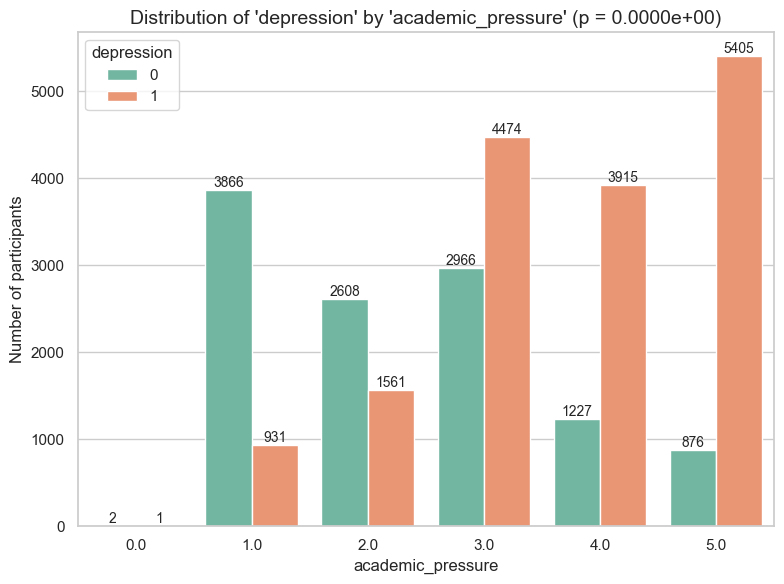

In [362]:
chi_square(student_depression_data, col="academic_pressure")

As we can see, the p-value is 0.0000e+00 which is significantly less than 0.05 and the expected values are very diferent than the observed. Therefore we can safely conclude that the $ H_0 $ can be rejected and the *academic pressure* actually affects students depression.

Let's now make two more tests

$ H_0 $ Students that have high financial stress aren't more likely to have depression.

$ H_A $ Students that have high financial stress are more likely to have depression.

Observed values:


depression,0,1
family_history_of_mental_illness,,
0,6321,8038
1,5224,8249


Chi2: 78.6290
p-value: 7.4942e-19
Degrees of freedom: 1
Expected values:


depression,0,1
family_history_of_mental_illness,,
0,5956.260959,8402.739041
1,5588.739041,7884.260959


Conclusion: There is a statistically significant relationship between 'family_history_of_mental_illness' and 'depression' (p < 0.05).


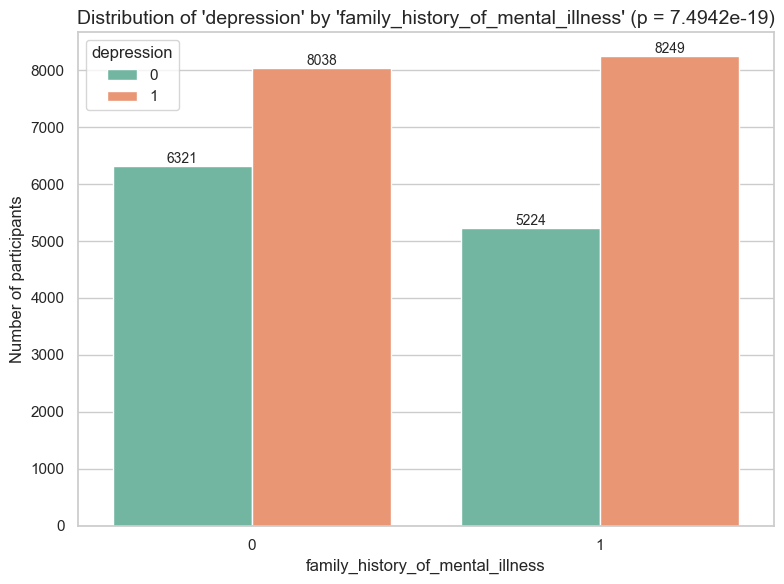

In [363]:
chi_square(student_depression_data, col="family_history_of_mental_illness")

As we can see, the p-value is 7.4942e-19 which is significantly less than 0.05 and the expected values are very diferent than the observed. Therefore we can safely conclude that the $ H_0 $ can be rejected and the *family history of mental illness* actually affects students depression.

And the final test

$ H_0 $ Students of diferent gender aren't more likely to have depression.

$ H_A $ Students of diferent gender are more likely to have depression.

Observed values:


depression,0,1
gender,,
0,5127,7199
1,6418,9088


Chi2: 0.1101
p-value: 7.4001e-01
Degrees of freedom: 1
Expected values:


depression,0,1
gender,,
0,5112.951638,7213.048362
1,6432.048362,9073.951638


Conclusion: There is no statistically significant relationship between 'gender' and 'depression' (p ≥ 0.05).


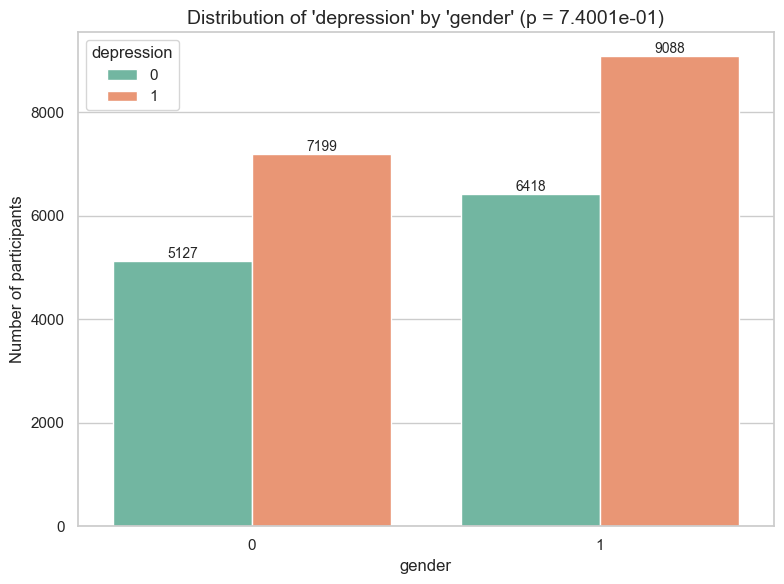

In [364]:
chi_square(student_depression_data, col="gender")

As we can see, the p-value is 0.74001 which is significantly larger than 0.05 and the expected values are very similar to the observed. Therefore we can safely conclude that the $ H_0 $ cannot be rejected and the *gender* doesn't affect students depression.

### Obsessive Compulsive Disorder - By Category

In [365]:
ocd_patient_data

,age,gender,ethnicity,marital_status,education_level,ocd_diagnosis_date,duration_of_symptoms_months,previous_diagnoses,family_history_of_ocd,obsession_type,compulsion_type,y_bocs_score_obsessions,y_bocs_score_compulsions,depression_diagnosis,anxiety_diagnosis,medications
0,32,0,African,Single,2.0,2016-07-15,203,MDD,0,Harm-related,Checking,17,10,1,1,SNRI
1,69,1,African,Divorced,2.0,2017-04-28,180,NaN,1,Harm-related,Washing,21,25,1,1,SSRI
2,57,1,Hispanic,Divorced,1.0,2018-02-02,173,MDD,0,Contamination,Checking,3,4,0,0,Benzodiazepine
3,27,0,Hispanic,Married,1.0,2014-08-25,126,PTSD,1,Symmetry,Washing,14,28,1,1,SSRI
4,56,0,Hispanic,Married,3.0,2022-02-20,168,PTSD,1,Hoarding,Ordering,39,18,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,38,1,Hispanic,Divorced,1.0,2019-01-10,53,MDD,0,Contamination,Washing,21,33,1,1,SSRI
1496,19,0,Hispanic,Divorced,0.0,2022-09-14,160,GAD,1,Hoarding,Praying,25,16,1,1,SSRI
1497,40,1,Asian,Married,2.0,2018-03-13,100,NaN,1,Contamination,Counting,2,15,1,1,Benzodiazepine
1498,37,0,Caucasian,Married,2.0,2018-04-14,210,GAD,1,Contamination,Washing,16,7,1,0,Benzodiazepine


#### Let's begin with the effect of depression and anxiety on the duration of symptoms (in months) of patients with OCD 

Do people that have only one - depression or anxiety have symptoms of OCD for longer (in months) or not?

Do people that have both depression and anxiety have symptoms of OCD for longer than those who have neither?

In [366]:
# 0 for not having the diagnosis and 1 for having it
def filter_by_conditions(df, depression = 0, anxiety = 0):
    return df[
        (df.depression_diagnosis == depression) &
        (df.anxiety_diagnosis == anxiety)
    ]

In [367]:
ocd_depression = filter_by_conditions(ocd_patient_data, depression = 1)
ocd_anxiety = filter_by_conditions(ocd_patient_data, anxiety = 1)
ocd_both = filter_by_conditions(ocd_patient_data, depression = 1, anxiety = 1)
ocd_neither = filter_by_conditions(ocd_patient_data)

Let's put them in collection

In [368]:
groups = [ocd_depression, ocd_anxiety, ocd_both, ocd_neither]

Now before proceeding to testing the means, we need to check the distributions for normality

In [369]:
[len(group) for group in groups]

[400, 379, 372, 349]

Since the size of the sets are small we can use the *Shapiro test*

In [370]:
[shapiro_test(group, "duration_of_symptoms_months") for group in groups]

Shapiro-Wilk Test for 'duration_of_symptoms_months':
Test Statistic = 0.9662
p-value = 0.0000
Result: Data is NOT normally distributed (reject H₀)

Shapiro-Wilk Test for 'duration_of_symptoms_months':
Test Statistic = 0.9421
p-value = 0.0000
Result: Data is NOT normally distributed (reject H₀)

Shapiro-Wilk Test for 'duration_of_symptoms_months':
Test Statistic = 0.9415
p-value = 0.0000
Result: Data is NOT normally distributed (reject H₀)

Shapiro-Wilk Test for 'duration_of_symptoms_months':
Test Statistic = 0.9651
p-value = 0.0000
Result: Data is NOT normally distributed (reject H₀)



[None, None, None, None]

We see that the distributions of the data is not normal therefore neither *t-test* nor *ANOVA* can be used with them. This is why earlier we ceated the functions for *Mann-Whitney U* and *Kruskal-Wallis*

Let's begin by testing if patients with both deseases have something with patients that do not have.

But first, make a function that plots the categories

In [371]:
def plot_group_hist(data1, data2, label1, label2, variable_name, title):
    sns.set_theme(style="whitegrid")
    
    plt.figure(figsize=(8, 5))
    sns.histplot(data1, color="skyblue", label=label1, kde=True, stat="density", alpha=0.6)
    sns.histplot(data2, color="salmon", label=label2, kde=True, stat="density", alpha=0.6)
    
    plt.title(title)
    plt.xlabel(variable_name)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

For these tests we are using the *Mann–Whitney U test*, because we compare two independent samples on a continuous variable and not having a normal distribution, in order to assess whether one group tends to have higher or lower values than the other.

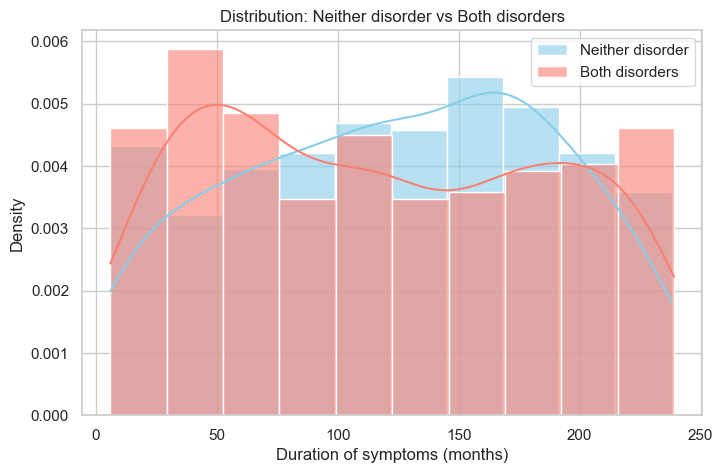

In [372]:
plot_group_hist(
    ocd_neither["duration_of_symptoms_months"],
    ocd_both["duration_of_symptoms_months"],
    "Neither disorder", "Both disorders",
    "Duration of symptoms (months)",
    "Distribution: Neither disorder vs Both disorders"
)

In [373]:
stat, p = st.mannwhitneyu(
    ocd_neither["duration_of_symptoms_months"],
    ocd_both["duration_of_symptoms_months"],
    alternative='two-sided'
)

In [374]:
print(f"Neither vs Both: U={stat}, p={p}")

Neither vs Both: U=68445.0, p=0.2065072102349973


The *Mann–Whitney U* test indicated no statistically significant difference in symptom duration between the *Neither* disorder group and the *Both* disorders group (U = 68445.0, p = 0.207). 

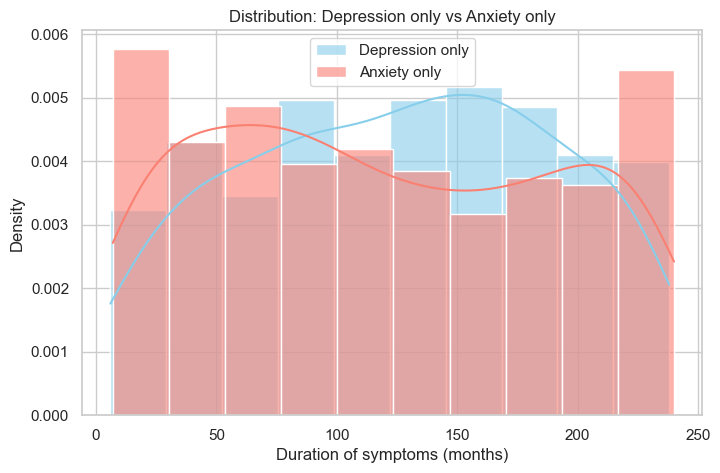

In [375]:
plot_group_hist(
    ocd_depression["duration_of_symptoms_months"],
    ocd_anxiety["duration_of_symptoms_months"],
    "Depression only", "Anxiety only",
    "Duration of symptoms (months)",
    "Distribution: Depression only vs Anxiety only"
)

In [376]:
stat, p = st.mannwhitneyu(
    ocd_depression["duration_of_symptoms_months"],
    ocd_anxiety["duration_of_symptoms_months"],
    alternative='two-sided'
)

In [377]:
print(f"Depression vs Anxiety: U={stat}, p={p}")

Depression vs Anxiety: U=80340.5, p=0.14809424749353214


The *Mann–Whitney U* test indicated no statistically significant difference in symptom duration between the *Depression* only group and the *Anxiety* only group (U = 80340.5, p = 0.148). 

Because the p-value is greater than the conventional *alpha level* of 0.05, we fail to reject the null hypothesis for both tests, meaning the observed difference in the sample is likely due to random variation rather than a true difference in the populations.

#### Another interesting question is if the obsession or compulsion Y-BOCS Scores reflect on the obsession or compulsion type

*The Yale–Brown Obsessive–Compulsive Scale (Y‑BOCS) is a clinician‑administered assessment used to measure the severity of obsessive and compulsive symptoms in individuals with OCD.*

For these tests we are using the Kruskal–Wallis H test, because we compare three or more independent groups on an ordinal or continuous variable without assuming a normal distribution, in order to assess whether at least one group differs significantly in its distribution from the others.

To begin with, we'll again need to group the data

In [378]:
def extract_scores_by_group(df, group_col, score_col):
    return [
        group[score_col].dropna().values
        for _, group in df.groupby(group_col)
    ]

In [379]:
obsession_groups = extract_scores_by_group(
    df = ocd_patient_data,
    group_col = "obsession_type",
    score_col = "y_bocs_score_obsessions"
)

In [380]:
compulsions_groups = extract_scores_by_group(
    df = ocd_patient_data,
    group_col = "compulsion_type",
    score_col = "y_bocs_score_compulsions"
)

But first, make a function that plots the categories

In [381]:
def plot_violin_scores_by_group(df, group_col, score_col, title=None, figsize=(10, 6), palette="Set2"):
    plt.figure(figsize=figsize)

    sns.violinplot(
        data=df,
        x=group_col,
        y=score_col,
        hue=group_col,
        palette=palette,
        inner="box",
        cut=0,
        legend=False,
    )

    plt.xticks()
    plt.title(title or f"Violin Plot of {score_col} by {group_col}")
    plt.tight_layout()

    plt.show()

Let's begin with the *Obsessions*

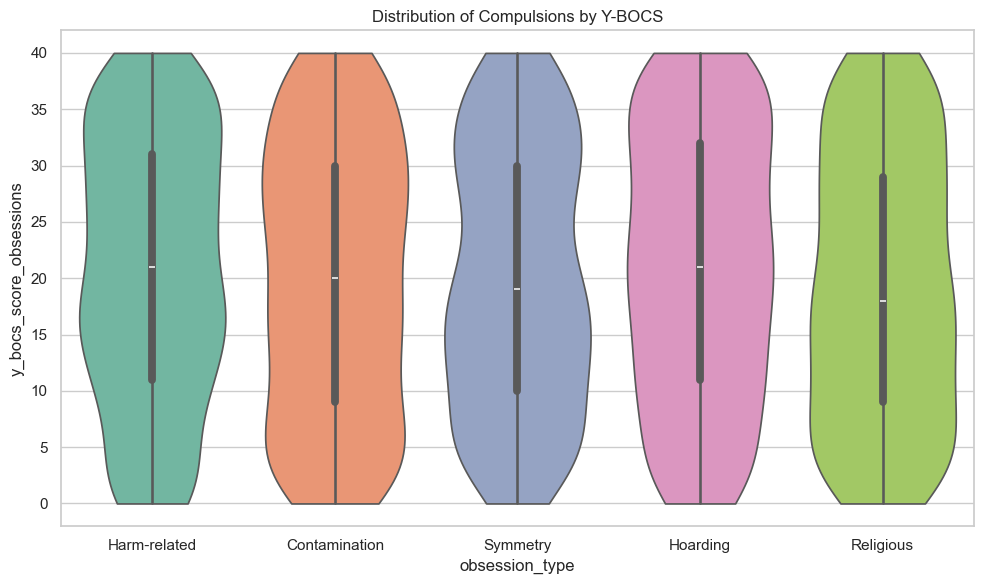

In [382]:
plot_violin_scores_by_group(
    df=ocd_patient_data,
    group_col="obsession_type",
    score_col="y_bocs_score_obsessions",
    title="Distribution of Compulsions by Y-BOCS"
)

In [383]:
obsession_stat, obsession_p = st.kruskal(*obsession_groups)

In [384]:
print(f"Compulsions: H={obsession_stat:.3f}, p={obsession_p:.3f}")

Compulsions: H=4.769, p=0.312


The *Kruskal–Wallis H* test showed no statistically significant difference in Y‑BOCS obsession scores across the different obsession types (H = 4.769, p = 0.312).
Because the p‑value is greater than the conventional alpha level of 0.05, we fail to reject the null hypothesis, indicating that any observed differences in median scores between obsession types are likely due to random variation rather than true differences in the population.

What about the *Compulsions*?

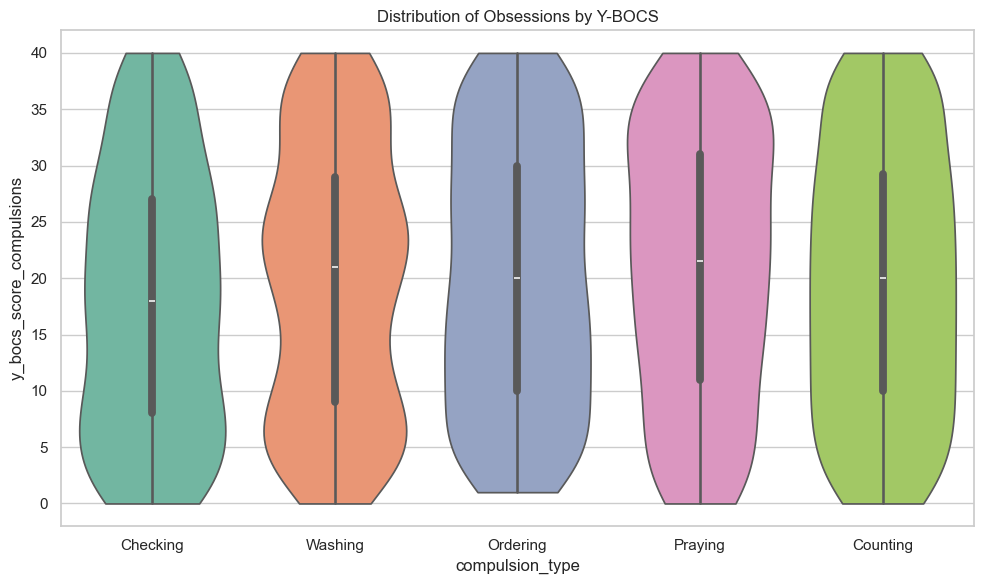

In [385]:
plot_violin_scores_by_group(
    df=ocd_patient_data,
    group_col="compulsion_type",
    score_col="y_bocs_score_compulsions",
    title="Distribution of Obsessions by Y-BOCS"
)

In [386]:
compulsion_stat, compulsion_p = st.kruskal(*compulsions_groups)

In [387]:
print(f"Compulsions: H={compulsion_stat:.3f}, p={compulsion_p:.3f}")

Compulsions: H=9.383, p=0.052


The *Kruskal–Wallis H* test indicated a difference in Y‑BOCS compulsion scores across compulsion types that approached, but did not reach, statistical significance (H = 9.383, p = 0.052).
Since the p‑value is slightly above 0.05, we cannot reject the null hypothesis at the 5% significance level, although the result suggests a possible trend toward differences that might warrant further investigation with a larger sample or more statistical power.

## Predicting a person's anxiety level (1 - 10) using Multiple Linear Regression

We've already cleaned the dataset. However, in order to do *Multiple Linear Regression*, we need to transform all nominal data. We will be using *one-hot-encoding*

Let's take a look at the data once more

In [397]:
enhanced_anxiety_data

,age,gender,occupation,sleep_hours,physical_activity_hrs_week,caffeine_intake_mg_day,alcohol_consumption_drinks_week,smoking,family_history_of_anxiety,stress_level_1_10,heart_rate_bpm,breathing_rate_breaths_min,sweating_level_1_5,dizziness,medication,therapy_sessions_per_month,recent_major_life_event,diet_quality_1_10,anxiety_level_1_10
0,29,Female,Artist,6.0,2.7,181,10,1,0,10,114,14,4,0,1,3,1,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,1,1,1,62,23,2,1,0,2,0,8,3.0
2,64,Male,Other,5.0,3.7,117,4,0,1,1,91,28,3,0,0,1,1,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,1,0,4,86,17,3,0,0,0,0,1,2.0
4,49,Female,Other,8.2,2.3,247,4,1,0,1,98,19,4,1,1,1,0,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,23,Female,Engineer,6.1,3.1,566,9,1,0,8,91,28,1,1,1,1,0,3,6.0
10996,50,Other,Teacher,6.6,3.6,64,17,1,0,7,95,17,3,0,0,2,0,7,3.0
10997,29,Male,Nurse,6.7,6.9,159,14,0,0,8,72,16,1,1,1,2,1,7,4.0
10998,53,Other,Artist,5.7,2.7,248,8,0,0,4,112,28,3,1,1,1,1,2,4.0


Let's pick our target - *anxiety_level_1_10*

In [398]:
target = enhanced_anxiety_data.anxiety_level_1_10

And then proceed by creating a features set - predictors

In [399]:
features = enhanced_anxiety_data[
    [
        "age",
        "sleep_hours",
        "physical_activity_hrs_week",
        "caffeine_intake_mg_day",
        "alcohol_consumption_drinks_week",
        "smoking",
        "family_history_of_anxiety",
        "stress_level_1_10",
        "heart_rate_bpm",
        "breathing_rate_breaths_min",
        "sweating_level_1_5",
        "dizziness",
        "medication",
        "therapy_sessions_per_month",
        "recent_major_life_event",
        "diet_quality_1_10"
    ]
]

Split the dataset into training (80%) and testing (20%) sets, random_state ensures reproducible results

In [400]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

Multiple Linear Regression model and fits it to the training data *(X_train, y_train)* to learn the best-fit coefficients for all input features

In [401]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Use the trained model to generate predictions for the test dataset (X_test)

In [402]:
predictions = model.predict(X_test)

Evaluate the model’s performance by printing the $ R^2 $ score (how well the model explains the variance in the target), the *Mean Squared Error* (average squared difference between actual and predicted values), and the first five predicted anxiety levels.

In [403]:
print("R^2 Score:", r2_score(y_test, predictions))
print("Mean Squared Error:", mean_squared_error(y_test, predictions))
print("Predicted Anxiety Levels:", predictions[:5])

R^2 Score: 0.7270465063639986
Mean Squared Error: 1.2647787383447473
Predicted Anxiety Levels: [5.26427929 4.82602099 6.98883174 1.418975   2.8754297 ]


R² Score (0.7270) – The model explains about 72.7% of the variance in the target variable.

Mean Squared Error (1.2648) – On average, predictions deviate from actual values by about √1.26 ≈ 1.12 units.

Predicted Anxiety Levels – The first five predicted scores for anxiety on a 1–10 scale.

Extract the learned coefficients from the trained Linear Regression model, match them to their corresponding feature names, sort them in descending order of value, and print the results.

In [404]:
coefficients = pd.Series(model.coef_, index=features.columns).sort_values(ascending=False)
print("Feature Coefficients:")
print(coefficients)

Feature Coefficients:
stress_level_1_10                  0.383161
therapy_sessions_per_month         0.253720
smoking                            0.085796
dizziness                          0.064591
medication                         0.060910
sweating_level_1_5                 0.046178
recent_major_life_event            0.026446
breathing_rate_breaths_min         0.012290
alcohol_consumption_drinks_week    0.010285
heart_rate_bpm                     0.004557
caffeine_intake_mg_day             0.002242
age                               -0.007937
diet_quality_1_10                 -0.034776
physical_activity_hrs_week        -0.071292
family_history_of_anxiety         -0.096003
sleep_hours                       -0.447868
dtype: float64


The largest positive coefficient is for stress_level_1_10 (0.383), meaning that for each one-point increase in stress level, the predicted anxiety score increases by 0.383 units, holding other variables constant.

The second largest is therapy_sessions_per_month (0.254), suggesting that individuals with higher anxiety levels tend to attend more therapy sessions.

Notably, sleep_hours (-0.448) has the strongest negative association, indicating that more sleep is linked to lower anxiety levels.

## Datasets

[Student Depression Dataset.](https://www.kaggle.com/datasets/hopesb/student-depression-dataset)

[Social Anxiety Dataset](https://www.kaggle.com/datasets/natezhang123/social-anxiety-dataset/data)

[OCD Patient Dataset: Demographics & Clinical Data](https://www.kaggle.com/datasets/ohinhaque/ocd-patient-dataset-demographics-and-clinical-data)